# File Info

Sample Training code for neural ODEs.

Learns simple limit cycle. 

In [1]:
import os
import sys
from torchdiffeq import odeint as odeint

sys.path.append(os.path.abspath(".."))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider
import types

import models.Neural_ODEs_v1 as nodes
import models.DynamicalSystems as ds

# Data Generation



In [2]:
lorenz = ds.Lorenz(sigma=10.0, rho=15.0, beta=8.0 / 3.0)

In [13]:
ic = [[1.0, 1.0, 1.0],
[-1.0, -1.0, 1.0]]

dt = 0.05

ic = torch.tensor(ic, dtype=torch.float32)

sol = lorenz.solve(x0=ic.T, t_span=(0, 20), dt=dt)

In [21]:
data_tensor = torch.stack((sol[0:-4, :, :], sol[1:-3, :, :]), dim=1)

In [22]:
data_tensor.shape 

torch.Size([396, 2, 3, 2])

In [23]:
data_tensor.shape[3]

2

In [26]:
list = []
for i in range(data_tensor.shape[3]):
    list.append(data_tensor[:,:,:,i])

data_tensor1 = torch.concat(list, dim=0)
data_loader = torch.utils.data.DataLoader(data_tensor1, batch_size=64, shuffle=True)

In [27]:
data_loader.dataset.shape #Num pairs - traj - dim

torch.Size([792, 2, 3])

# Model 

In [28]:
model = nodes.NODE2(input_dim=3, output_dim=3, hidden_dim=32, depth=4, activation_func=nn.Tanh())

In [29]:
t_eval = torch.arange(0, 0.1, dt)
t_eval

#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [30]:
trainer = nodes.Trainer(model=model, data_loader=data_loader, optimizer=optimizer, loss_fn=loss_fn, t_eval=t_eval, dt=dt)

In [31]:
trainer.train(num_epochs=400, t_eval=t_eval)

Current Loss: 0.6220296621322632  - Epochs: 0: 100%|██████████| 400/400 [00:45<00:00,  8.73it/s]


Text(0.5, 0, 'Epochs')

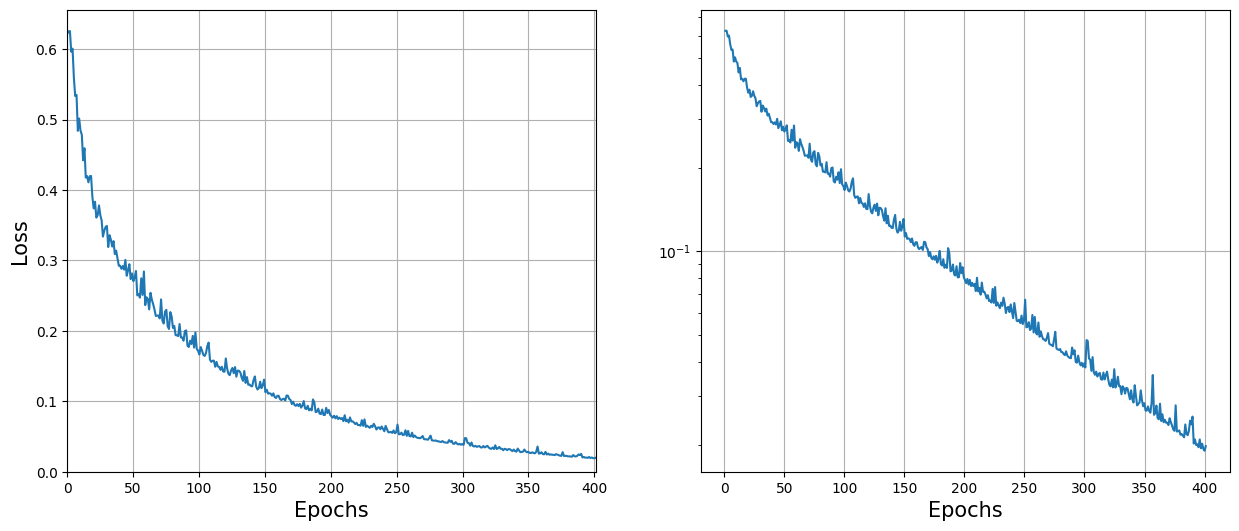

In [32]:
### Analysis  
epochs = len(trainer.loss_list)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(trainer.loss_list)), trainer.loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(trainer.loss_list))
ax2.plot(e_pts[1:], trainer.loss_list[1:])

#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [33]:
pred_x = odeint(func=model, y0=data_loader.dataset[:,0,:], t=t_eval, method='rk4', options={'step_size': dt})  #(time, batch, traj, dim)
loss = loss_fn(pred_x[-1, :, :, ], data_loader.dataset[:,1,:]) 
loss_list.append(loss.item())
print(f'Final Loss: {loss.item()}')

Final Loss: 0.019708463922142982


# Analyzing the trained model

## Data Generation with trained NODE

In [ ]:
a = torch.linspace(-2, 2, 10)  
b = torch.linspace(-2, 2, 10)  
c = torch.arange(-1, 8.0, 0.1)

pts = torch.cartesian_prod(a, b)  # (num_pts, dim)
pts.shape


In [34]:
pts.shape

torch.Size([100, 2])

In [36]:
t_Start_pred = 0; t_Final_pred = 20; dt_pred = 0.05
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt_pred)

node_data = odeint(func=model, y0=ic, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})
true_data = odeint(func=lorenz.f, y0=ic.T, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})



node_data = node_data.detach().numpy()
true_data = true_data.detach().numpy()

print(node_data.shape); print(true_data.shape)

(400, 2, 3)
(400, 3, 2)


## Plotting phase space

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.plot(node_data[:, :, 0],
                node_data[:, :, 1], node_data[:, :, 2],
                linewidth=0.5, alpha=0.5, linestyle='--', color='royalblue')
ax2.plot(true_data[:, :, 0],
                true_data[:, :, 1], true_data[:, :, 2],
                linewidth=0.5, alpha=0.5, linestyle='--', color='royalblue')
ax1.set_title(f"NODE r(0)={1}")
ax2.set_title(f"True r(0)={1}")
plt.show()

AttributeError: Figure.set() got an unexpected keyword argument 'projection'

In [ ]:
# Plotting time traces: 

In [44]:
traj = 50
t = t_eval_pred.detach().numpy()
x = node_data[:, traj, :]
x_true = true_data[:, traj, :]



In [48]:
def cartesian_to_polar(x, y):
    """
    Convert Cartesian coordinates to polar coordinates.
    
    Parameters:
    x, y: float or array-like
        Cartesian coordinates
    
    Returns:
    r: float or array
        Radius (distance from origin)
    theta: float or array
        Angle in radians (from positive x-axis)
    """
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def polar_to_cartesian(r, theta):
    """
    Convert polar coordinates to Cartesian coordinates.
    
    Parameters:
    r: float or array-like
        Radius (distance from origin)
    theta: float or array-like
        Angle in radians (from positive x-axis)
    
    Returns:
    x, y: float or array
        Cartesian coordinates
    """
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

In [49]:

r, theta = cartesian_to_polar(x[:, 0], x[:, 1])
r_true, theta_true = cartesian_to_polar(x_true[:, 0], x_true[:, 1])

In [50]:
t.shape

(200,)

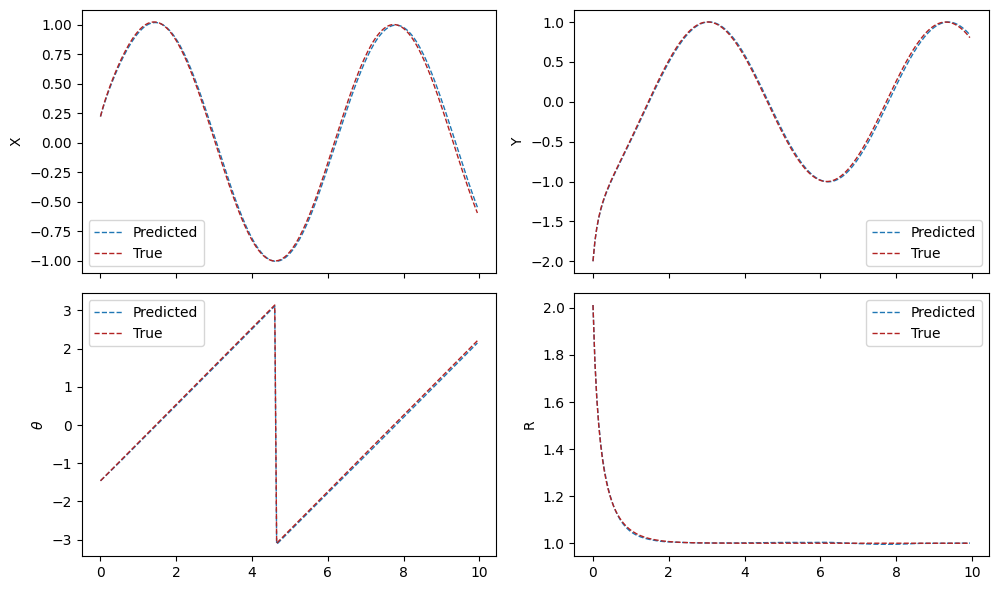

In [53]:


fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=False)


axes[0, 0].plot(t,
                x[:, 0],
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[0, 0].plot(t, x_true[:, 0],
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[0, 0].set_ylabel('X')

axes[0, 0].legend()


axes[0, 1].plot(t,
                x[:, 1],
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[0, 1].plot(t, x_true[:, 1],
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[0, 1].set_ylabel('Y')
axes[0, 1].legend()

axes[1, 1].plot(t,
                r,
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[1, 1].plot(t, r_true,
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[1, 1].set_ylabel('R')
axes[1, 1].legend()


axes[1, 0].plot(t,
                theta,
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[1, 0].plot(t, theta_true,
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[1, 0].set_ylabel(r'$\theta$')
axes[1, 0].legend()
plt.tight_layout()
plt.show()